In [ ]:
import gym
from gym import spaces
import pandas as pd
import numpy as np
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation, Embedding, Dropout
from keras.optimizers import Adam,RMSprop
from keras import backend as K

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

In [ ]:
# connect to drive to pull data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = './drive/My Drive/MDA9170 Project/'#please go to the kaggle link and put the dataset in google drive before running

df = pd.read_csv(path + 'stocks.csv')

# Data Preprocessing


In [ ]:
df.head()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,date,symbol,open,close,low,high,volume
0,2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
1,2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2,2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
3,2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
4,2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


In [ ]:
df["reward"] = df["open"] - df["close"]
df = df.drop(columns = ["low","high","volume","open","close","date"])
df.head()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,symbol,reward
0,WLTW,-2.409996
1,WLTW,5.259995
2,WLTW,1.430000
3,WLTW,-1.140000
4,WLTW,2.040001


In [ ]:
df_new = df[df.symbol == "FB"].reset_index()
df_new = df_new.rename(columns={'reward': 'FB'}).drop(columns=["index","symbol"])

dfs = df[df.symbol == "AMZN"].reset_index()
df_new["AMZN"] = dfs["reward"]

dfs = df[df.symbol == "AAPL"].reset_index()
df_new["AAPL"] = dfs["reward"]

dfs = df[df.symbol == "NFLX"].reset_index()
df_new["NFLX"] = dfs["reward"]

dfs = df[df.symbol == "GOOGL"].reset_index()
df_new["GOOGL"] = dfs["reward"]

df_new = df_new.dropna()

final_test = df_new.tail(60)
final_test = final_test.reset_index().drop(columns=["index"])

final_30 = final_test[30:60].reset_index().drop(columns=["index"])

df_new = df_new.drop([i for i in range(948,1008)])

df_copy = df_new.copy().drop([i for i in range(930,948)])

df_new.shape



/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(948, 5)

In [ ]:
df_new.head()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,FB,AMZN,AAPL,NFLX,GOOGL
0,-0.559999,2.350006,-0.082857,0.291429,0.100098
1,0.109999,-1.260009,0.031429,0.294286,1.596589
2,-0.750000,2.350006,0.487143,-0.255714,8.808808
3,-0.729999,2.009995,0.167143,0.245714,7.657654
4,0.450001,-2.960006,-0.240002,-0.115715,-5.015015


In [ ]:
def convert(df_new):

  names = ["FB","AMZN","AAPL","NFLX","GOOGL"]
  for i in range(5):
    for j in range(i+1,5):
      name = names[i]+"_"+names[j]
      df_new[name] = df_new[names[i]] + df_new[names[j]]
      for x in range(j+1,5):
        name = names[i]+"_"+names[j]+"_"+names[x]
        df_new[name] = df_new[names[i]] + df_new[names[j]] + df_new[names[x]]

    names_temp = names.copy()
    del names_temp[i]
    name = names_temp[0]+"_"+names_temp[1]+"_"+names_temp[2]+"_"+names_temp[3]
    df_new[name] = df_new[names_temp[0]] + df_new[names_temp[1]] + df_new[names_temp[2]] + df_new[names_temp[3]]

  df_new["FB"+"AMZN"+"AAPL"+"NFLX"+"GOOGL"] = df_new["FB"] + df_new["AMZN"] + df_new["AAPL"] + df_new["NFLX"] + df_new["GOOGL"]

  df_new.head()

  return df_new

df_new = convert(df_new)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df_new.describe()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,FB,AMZN,AAPL,NFLX,GOOGL,FB_AMZN,FB_AMZN_AAPL,FB_AMZN_NFLX,FB_AMZN_GOOGL,FB_AAPL,...,AMZN_GOOGL,FB_AAPL_NFLX_GOOGL,AAPL_NFLX,AAPL_NFLX_GOOGL,AAPL_GOOGL,FB_AMZN_NFLX_GOOGL,NFLX_GOOGL,FB_AMZN_AAPL_GOOGL,FB_AMZN_AAPL_NFLX,FBAMZNAAPLNFLXGOOGL
count,948.000000,948.000000,948.000000,948.000000,948.000000,948.000000,948.000000,948.000000,948.000000,948.000000,...,948.000000,948.000000,948.000000,948.000000,948.000000,948.000000,948.000000,948.000000,948.000000,948.000000
mean,-0.009441,-0.144504,0.051483,-0.026706,0.096177,-0.153945,-0.102462,-0.180651,-0.057769,0.042042,...,-0.048328,0.111513,0.024777,0.120954,0.147659,-0.084475,0.069471,-0.006286,-0.129168,-0.032992
std,1.181737,3.409818,0.880902,0.611546,3.607517,3.601055,3.977160,3.867681,6.088155,1.497557,...,5.953528,4.466350,1.178525,4.261305,4.070120,6.327472,3.790524,6.533877,4.248307,6.775084
min,-5.059997,-14.630005,-4.394287,-3.412857,-15.370361,-14.860009,-16.760011,-16.651439,-22.527688,-7.124282,...,-22.297684,-16.141790,-5.154287,-15.431791,-15.736076,-24.319118,-15.066076,-24.427690,-18.551440,-26.219119
25%,-0.700000,-2.167503,-0.407500,-0.323214,-2.052040,-2.442493,-2.495720,-2.504289,-3.907476,-0.875714,...,-3.823566,-2.543515,-0.648567,-2.403045,-2.323385,-4.109271,-2.227885,-4.093805,-2.725707,-4.357336
50%,-0.029999,-0.070000,0.009287,0.018570,0.100098,-0.139995,-0.188574,-0.082860,-0.145016,0.015002,...,-0.160759,-0.055899,0.029999,-0.027958,0.070625,-0.093163,0.068517,-0.291258,-0.188574,-0.344598
75%,0.649995,1.869995,0.533573,0.300358,2.059548,2.082500,2.366429,2.140351,3.693788,0.839287,...,3.575398,2.702796,0.697143,2.524743,2.374232,3.953319,2.222651,3.919368,2.498570,4.231886
max,5.440002,15.160003,4.302856,2.621429,30.300324,18.340004,18.372864,16.770004,34.950325,6.908570,...,33.220322,33.184614,4.769997,31.454611,31.293183,35.111753,30.461752,35.943184,16.802864,36.104612


In [ ]:
stock_names = df_new.columns

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Costumizing Environment

In [ ]:
class PortfolioEnv(gym.Env):
    """A stock trading environment for OpenAI gym"""
    metadata = {'render.modes': ['human']}

    def __init__(self, data):
        super(PortfolioEnv, self).__init__()

        self.df = data

        self.action_space = spaces.Discrete(31)

        self.observation_space = spaces.Box(
            low=-50, high=100, shape=(31,1), dtype=np.float16)
        
        self.current_step = 0

    def _next_observation(self):

        obs = self.df.iloc[self.current_step,:]

        return obs

    def step(self, action):
        # Execute one time step within the environment

        self.current_step += 1

        reward = self.df.iloc[self.current_step-1, action]

        done = self.current_step >= 30

        obs = self._next_observation()

        return obs, reward, done, {}

    def reset(self):

        # Set the current step to the beginning of a 30 day trial

        self.current_step = 0

        return self._next_observation()

    def render(self, mode='human', close=False):
        pass


In [ ]:

# Create an instance of the custom environment with your data
env = PortfolioEnv(df_new)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Deep Q-Network

In [ ]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [ ]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 512)
        self.layer2 = nn.Linear(512, 512)
        self.layer3 = nn.Linear(512, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)
      
      

In [ ]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the AdamW optimizer
BATCH_SIZE = 30
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 500
TAU = 0.005
LR = 1e-4

actions_res = []

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)

memory = ReplayMemory(1000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.legend()
        plt.title('Result')
    else:

        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Average Batch Reward')
    plt.plot(durations_t.numpy(),label='Average Batch Reward')
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 30:
        means = durations_t.unfold(0, 30, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(29), means))
        plt.plot(means.numpy(),label = "Average over last 30 epoches")


    if is_ipython:
        if not show_result:

            display.display(plt.gcf())
            display.clear_output(wait=True)



In [ ]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    actions_res.append(action_batch.numpy())

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

    return torch.mean(reward_batch).item()


Complete


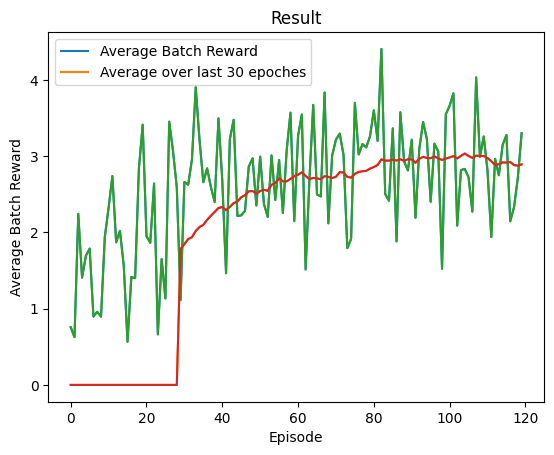

In [ ]:
num_episodes = 120

action_res = []

for i_episode in range(num_episodes):
    # Initialize the environment and get it's state
    state = env.reset()

    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated,  _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated 
        
        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        reward = optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(reward)
            plot_durations()
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

In [ ]:
for i in range(num_episodes):
  count = 0
  for j in actions_res:
    if i == count:
      continue
    if np.array_equal(actions_res[i],j):
      print("found")
    count+=1

In [ ]:
final_converted = convert(final_30.copy())
dqn_actions = []

approximated_values = []

for i in range(30):
  step = torch.tensor(np.array([final_converted.iloc[i]]), dtype=torch.float32, device=device).unsqueeze(0)
  dqn_actions.append(policy_net(step[0]).max(1)[1].view(1, 1).item())
  approximated_values.append(policy_net(step[0]).tolist()[0])

# Recurrent Neural Network - LSTM

In [ ]:
data=np.array([df_copy])

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
data = data.reshape(31,30,5)
train_df = data[0:25,:,:]
target = data[1:26,:,:]

val_df = data[25:30,:,:]
val_target = data[26:31,:,:]


In [ ]:
model = Sequential()
model.add(LSTM(5,activation='relu',return_sequences=True,input_shape=(30,5))) #input takes any steps, two features (var1 and var2)

model.add(Dense(5))



model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])

epochs = 200
batch_size = 1
model.summary()
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))
model.compile(optimizer=Adam(lr=0.001), loss=root_mean_squared_error)#change it here to switch between rmse and mse
model.fit(train_df, target, epochs=epochs, validation_data=(val_df ,val_target) ,batch_size=batch_size)

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_17 (LSTM)              (None, 30, 5)             220       
                                                                 
 dense_17 (Dense)            (None, 30, 5)             30        
                                                                 
Total params: 250
Trainable params: 250
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/200
25/25 [==============================] - 1s 18ms/step - loss: 2.3419 - val_loss: 2.4604
Epoch 2/200
25/25 [==============================] - 0s 7ms/step - loss: 2.3116 - val_loss: 2.4330
Epoch 3/200
25/25 [==============================] - 0s 8ms/step - loss: 2.2954 - val_loss: 2.4170
Epoch 4/200
25/25 [==============================] - 0s 8ms/step - loss: 2.2858 - val_loss: 2.4066
Epoch 5/200
25/25 [==============================] - 0s 7ms/step - loss: 2.2790 - val_loss: 2.4005
Epoch 6/200
25/25 [==============================] - 0s 7ms/step - loss: 2.2745 - val_loss: 2.3956
Epoch 7/200
25/25 [==============================] - 0s 7ms/step - loss: 2.2714 - val_loss: 2.3914
Epoch 8/200
25/25 [==============================] - 0s 7ms/step - loss: 2.2687 - val_loss: 2.3882
Epoch 9/200
25/25 [==============================] - 0s 7ms/step - loss: 2.2666 - val_loss: 2.3858
Epoch 10/200
25/25 [==============================] - 0s 7ms/step - loss: 2.2650 - val_loss: 2.3836
Epoch 11

In [ ]:
test = np.array([final_test])

In [ ]:
test = test.reshape(2,30,5)
test_df = test[0:1,:,:]
test_target = test[1:2,:,:]

In [ ]:
test_pred = model.predict(test_df)

1/1 [==============================] - 0s 195ms/step


In [ ]:
lstm_actions = np.argmax(test_pred[0], axis=1).tolist()

In [ ]:
res = [[] for i in range(5)]
for i in test_pred[0]:
  for j in range(5):
    res[j].append(i[j])

targets = [[] for i in range(5)]
for i in test[0]:
  for j in range(5):
    targets[j].append(i[j])

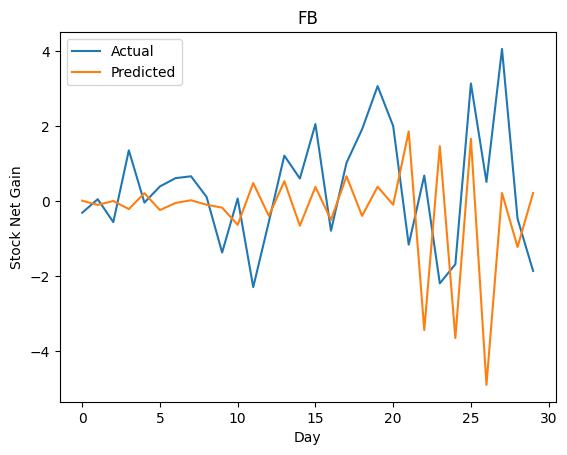

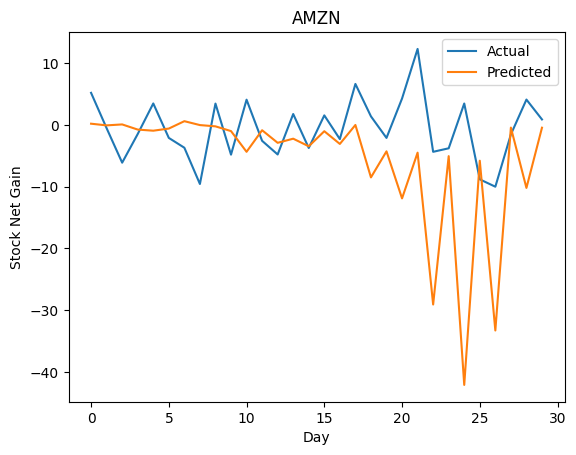

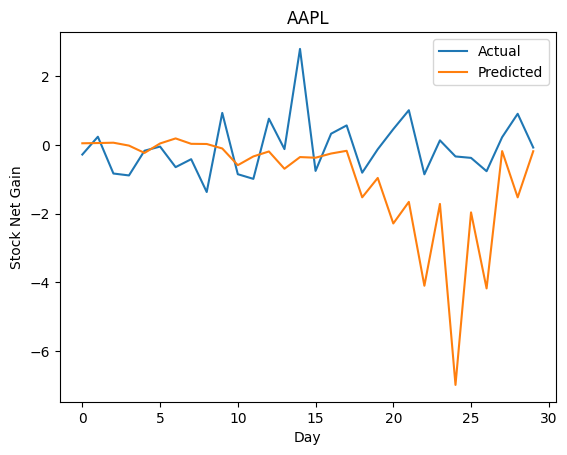

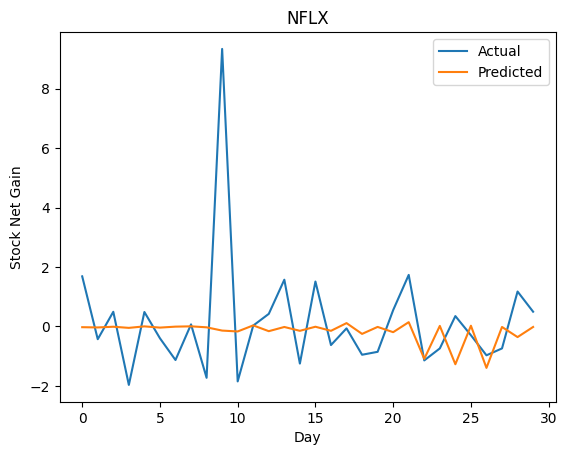

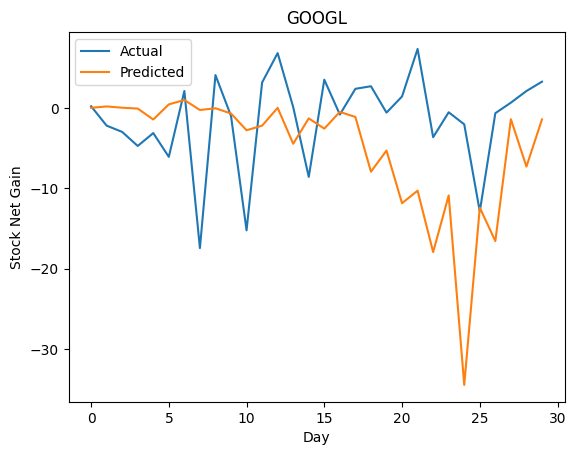

In [ ]:
for i in range(5):
  plt.title(final_30.columns[i])
  plt.xlabel('Day')
  plt.ylabel('Stock Net Gain')
  plt.plot(targets[i], label = "Actual")
  plt.plot(res[i], label = "Predicted")
  plt.legend()
  plt.show()

# Non-machine Learning - Modified Value Averaging

In [ ]:
def ValueAveraging(df):
  names_df = df.columns.tolist()
  num_to_buy = 1
  net_gain = 0
  for i in range(len(df)):
    chosen = random.sample(names_df, num_to_buy)
    temp_gain = 0
    for j in chosen:
      temp_gain += df[j][i]
    if temp_gain >=0:
      num_to_buy = min(num_to_buy+1,5)
    net_gain += temp_gain
  return net_gain

# Comparison of results

In [ ]:
final_converted = convert(final_30.copy())

def FindValue(actions, df):
  net_gain = 0
  for i in range(len(actions)):
    net_gain += df.iloc[i,actions[i]]
  return net_gain

dqn_values = FindValue(dqn_actions, final_converted)
lstm_values = FindValue(lstm_actions, final_30)

In [ ]:
dqn_values

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


28.2573182012

In [ ]:
lstm_values

-5.114198624799947

In [ ]:
values = []
for i in range(500):

  values.append(ValueAveraging(final_30))

np.mean(values)

-0.6247334901070701

In [ ]:
sum(sum(np.array(final_30)))

-8.854467047499938

# Actual Optimal Policy

In [ ]:
policy = np.argmax(np.array(final_converted),axis=1)
optimal_values = FindValue(policy.tolist(), final_converted)

In [ ]:
optimal_values

129.39229593379986

In [ ]:
policy_5 = np.argmax(np.array(final_30),axis=1)
optimal_values = FindValue(policy_5.tolist(), final_30)
optimal_values

80.18028984210002

In [ ]:
policy_min = np.argmin(np.array(final_converted),axis=1)
minimal_values = FindValue(policy_min.tolist(), final_converted)
minimal_values

-137.16246955269978